In [ ]:
from Models.model_sources.markov_source import MarkovChain
from Models.MMC import MMC
from Models.DBN import FMC
import requests
from Models.model_sources.mtd_source import MTD
from Models.model_sources.path_encoder import PathEncoder, SequenceCutter

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [32]:
# use hillclimbing and misalignment combinment
# take a look at java code


In [42]:
interval = "5m"
symbol = "AAPL.US"
def get_crypto_price(symbol, exchange,interval, start_date = None):
    api_key = '630d712fd8bd74.01254339'
    api_url = f'https://eodhistoricaldata.com/api/intraday/{symbol}?api_token={api_key}&interval={interval}&fmt=json'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df)
    df['close'] = df['close'].astype(float)
    return df

# go for 100 states
# add volume, increase to 24 states
# fix training data for MTD

df = get_crypto_price(symbol = symbol, exchange = 'USD', interval = interval)
print(df.head())
df = df.drop(["gmtoffset", "datetime", "timestamp","volume"], axis=1)

df['Change'] = df['close'].diff()

df['Change_enc'] = np.nan
std = df.std()['Change']

df.loc[df.Change < 0.0, 'Change_enc'] = "drop"
df.loc[df.Change > 0.0, 'Change_enc'] = "rise"

df.loc[df.Change <= -std, 'Change_enc'] = "big drop"
df.loc[df.Change <= -2*std, 'Change_enc'] = "bigger drop"
df.loc[df.Change <= -3*std, 'Change_enc'] = "biggest drop"
df.loc[df.Change >= std, 'Change_enc'] = "big rise"
df.loc[df.Change >= 2*std, 'Change_enc'] = "bigger rise"
df.loc[df.Change >= 3*std, 'Change_enc'] = "biggest rise"

#df['volume_bin'] = pd.qcut(df['volume'], q=6, labels=[i for i in range(6)])
#df['open_bin'] = pd.qcut(df['open'], q=4, labels=[i for i in range(4)])
#df['close_bin'] = pd.qcut(df['close'], q=4 , labels=[i for i in range(4)])

df['ma5'] = df['close'].rolling(window=5, min_periods=5).mean()
df['ma8'] = df['close'].rolling(window=8, min_periods=8).mean()
df['ma13'] = df['close'].rolling(window=13, min_periods=13).mean()

"""columns = ["close_bin","open_bin"] #"volume_bin"]

for c in columns:
    res = [None, None, None]
    res.extend([(df.iloc[i-1][c],df.iloc[i-2][c], df.iloc[i-3][c])  for i in range(3, len(df))])
    df[c+'_history'] = res
"""
#df.dropna(inplace=True)
df = df.reset_index()

#df['ma_cross'] = [[x for _,x in sorted(zip([row['ma5'],row['ma8'],row['ma13']],[0,1,2]))] for key,row in df.iterrows()]


    timestamp  gmtoffset             datetime        open        high  \
0  1654003800          0  2022-05-31 13:30:00  150.000000  150.121994   
1  1654004100          0  2022-05-31 13:35:00  148.315902  148.779998   
2  1654004400          0  2022-05-31 13:40:00  148.199996  148.399993   
3  1654004700          0  2022-05-31 13:45:00  147.770004  148.490005   
4  1654005000          0  2022-05-31 13:50:00  148.020004  148.539993   

          low       close     volume  
0  148.300003  148.320007  5858531.0  
1  148.009994  148.199996  1865629.0  
2  147.580001  147.759994  1810754.0  
3  147.750000  148.019302  1784333.0  
4  147.779998  147.829895  1415227.0  


In [43]:
df['gain'] = df['Change'].clip(lower=0).round(2)
df['loss'] = df['Change'].clip(upper=0).abs().round(2)
df['gain'] = df['gain'].fillna(0)
df['loss'] = df['loss'].fillna(0)

window_length = 14
df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()
df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()

df['ma_cross'] =\
    ["".join([str(x) for _,x in sorted(zip([row['ma5'],row['ma8']],[0,1]))]) for key,row in df.iterrows()]

#df['ma_cross'] = [''.join([str(x) for _,x in sorted(zip([row['ma5'],row['ma8'],row['ma13']],[0,1,2]))]) for key,row in df.iterrows()]

df['ma_cross_new'] = [0] + [1 if df.iloc[i]['ma_cross'] != df.iloc[i-1]['ma_cross'] else 0 for i in range(1, len(df))]

In [44]:
df[['ma_cross', 'ma_cross_new']].head(50)

,ma_cross,ma_cross_new
0,01,0
1,01,0
2,01,0
3,01,0
4,01,0
5,01,0
6,01,0
7,01,0
8,01,0
9,01,0


In [45]:
window_length = 14
# Get WMS averages
# try to get more data
#
# Average Gains
for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
    df['avg_gain'].iloc[i + window_length + 1] = \
        (df['avg_gain'].iloc[i + window_length] *
         (window_length - 1) +
         df['gain'].iloc[i + window_length + 1]) \
        / window_length
# Average Losses
for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
    df['avg_loss'].iloc[i + window_length + 1] = \
        (df['avg_loss'].iloc[i + window_length] *
         (window_length - 1) +
         df['loss'].iloc[i + window_length + 1]) \
        / window_length
# View initial results
print(df[window_length-1:window_length+5])

/var/folders/zx/yk985wb16xsc86xkvb1kqg500000gn/T/ipykernel_6175/3763601371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_gain'].iloc[i + window_length + 1] = \
/var/folders/zx/yk985wb16xsc86xkvb1kqg500000gn/T/ipykernel_6175/3763601371.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_loss'].iloc[i + window_length + 1] = \


    index        open        high         low       close    Change  \
13     13  148.379898  148.479995  148.179992  148.342193 -0.032807   
14     14  148.345001  148.698196  148.199996  148.698196  0.356003   
15     15  148.699005  148.789993  148.449096  148.479995 -0.218201   
16     16  148.470092  148.669998  148.339996  148.666198  0.186203   
17     17  148.679992  148.720001  148.350006  148.518997 -0.147201   
18     18  148.509994  148.979995  148.470001  148.839996  0.320999   

   Change_enc         ma5         ma8        ma13  gain  loss  avg_gain  \
13       drop  148.064221  147.800638  147.853483  0.00  0.03  0.110000   
14   big rise  148.280859  147.952287  147.891807  0.36  0.00  0.135714   
15       drop  148.377078  148.118538  147.947191  0.00  0.22  0.126020   
16       rise  148.512316  148.270687  147.996952  0.19  0.00  0.130590   
17       drop  148.541116  148.383686  148.049960  0.00  0.15  0.121262   
18   big rise  148.640676  148.488822  148.123730  0

In [46]:
# Calculate RS Values
df['rs'] = df['avg_gain'] / df['avg_loss']
df = df.iloc[30:]
def convert_rs(value):
    if value > .70:
        return 0
    if value < .30:
        return 1
    return 2

df['rs_state'] = [convert_rs(df['rs'].values[i]) for i in range(len(df))]

/var/folders/zx/yk985wb16xsc86xkvb1kqg500000gn/T/ipykernel_6175/3583435095.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rs_state'] = [convert_rs(df['rs'].values[i]) for i in range(len(df))]


## Fit models

In [49]:
values = [df.Change_enc, df.ma_cross, df.rs_state]

data_to_fit = np.array([''.join([str(v.values[i]) for v in values]) for i in range(len(df))])

order = 7

sc = SequenceCutter(order)
x, y = sc.transform(data_to_fit)

pe = PathEncoder(order)
pe.fit(x, y)

x_tr, y_tr = pe.transform(x, y)

In [50]:
from sklearn.model_selection import train_test_split

div = round(len(x_tr)*.90)
X_train, X_test, y_train, y_test = x_tr[div:, :], x_tr[:div, :], y_tr[div:], y_tr[:div]
#(X_train, X_test, y_train, y_test) = train_test_split(x_tr, y_tr)

print(max(X_train.flatten()), len(set(X_train.flatten())))
amount_to_average = 1

sgo_type = "greedy"
methods = [MMC, FMC] #HMC] #FMC]
types = [m.__name__ for m in methods]

state_count = len(np.unique(x_tr))

mmc = None
for _ in range(amount_to_average):
    args_training = {"X_train": X_train, "y_train": y_train}
    args_testing =   {"X_test": X_test, "y_test": y_test}
    results_training = []
    results_testing = []

    for m in methods:
        model = m(state_count, order=order)
        training = MarkovChain.calculate_time(model.train, args_training)
        testing = MarkovChain.calculate_time(model.test, args_testing)

        if m.__name__ == "MMC":
            mmc = model
            pred_res = []
            drop_indexes = [key for key,value in pe.label_dict_inverse.items() if "drop" in value]
            rise_indexes = [key for key,value in pe.label_dict_inverse.items() if "rise" in value]

            for lag in X_test:

                prob_values = mmc.cpt[mmc.find_high(lag, mmc.index_dict)]
                drop_prob = sum([prob_values[key] for key in drop_indexes])

                if drop_prob >= .5:
                    pred_res.append(drop_indexes[0])
                else:
                    pred_res.append(rise_indexes[0])
        else:
            pred_res = model.predict(X_test)

        #results_training.append(training[0])
        results_testing.append(testing[0])

        count = 0
        for i,p in enumerate(pred_res):

            if "drop" in pe.label_dict_inverse[p] and "drop" in pe.label_dict_inverse[y_test[i]]:
                count += 1
            elif "rise" in pe.label_dict_inverse[p] and "rise" in pe.label_dict_inverse[y_test[i]]:
                count += 1
        print(count/len(pred_res))

        print(model.__class__.__name__)
        print(f"Training: {training}")
        print(f"Testing: {testing}")
        print("")

    print(results_testing)

34 29
0.49853372434017595
MMC
Training: (None, 0.109093)
Testing: (0.24564429877522856, 0.588304)

0.48956356736242884
FMC
Training: (None, 0.16561)
Testing: (0.3141279972399517, 3.227963)

[0.24564429877522856, 0.3141279972399517]


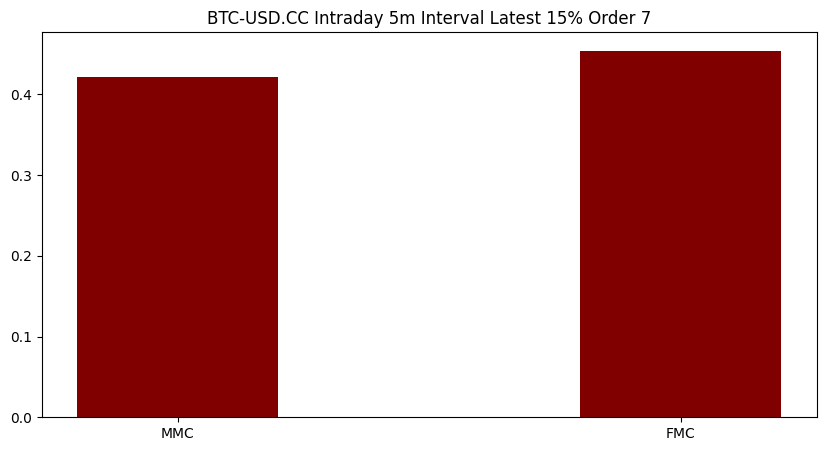

In [96]:
def create_bar_graph(data, title, types):
    plt.figure(figsize=(10, 5))

    # creating the bar plot
    plt.bar(types, data, color='maroon',
            width=0.4)

    plt.title(title)
    plt.show()
[m.__name__ for m in methods if m != MTD]

create_bar_graph(results_testing, f"{symbol} Intraday {interval} Interval Latest 15% Order {order}", [m.__name__ for m in methods if m != MTD])

In [37]:
[m.__name__ for m in methods]

['MMC', 'FMC', 'HMC']

## Choose model

In [39]:
mmc.predict([x_tr[-1]])

[0]